In [ ]:
pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 12.0 MB/s eta 0:00:00


In [ ]:
pip install google-cloud-vision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.6/459.6 kB 8.5 MB/s eta 0:00:00


In [ ]:
pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 65.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 18.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12

In [ ]:
!pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 6.0 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import dlib
import numpy as np
import pandas as pd
import shutil
import random
import boto3
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import the tqdm library
from collections import Counter
from imutils import build_montages
from imutils import paths
import argparse
import imutils
import cv2
from sentence_transformers import SentenceTransformer, util
from google.cloud import vision
import io
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')
from textblob import TextBlob
from flair.models import TextClassifier
from flair.data import Sentence

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print(cv2.__version__)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


4.8.0


In [ ]:
# Before displaying, make sure to mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy label images files in reduced amount to another folder:

# Source directory containing the images
directory_path = "/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/02_FaceCount_Test/00_image_faces_train_01"

# Destination directory where the selected images will be copied
destination_path = "/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/02_FaceCount_Test/01_image_faces_train_01_z8th_amount"

# Ensure the destination directory exists
os.makedirs(destination_path, exist_ok=True)

# Get a list of all files in the source directory
all_files = os.listdir(directory_path)

# Randomly select 50% of the files
#selected_files = random.sample(all_files, len(all_files) // 2)

# Randomly select 25% of the files
selected_files = random.sample(all_files, len(all_files) // 8)


# Copy the selected files to the destination directory with a loading bar
for file_name in tqdm(selected_files, desc="Copying files"):
    source_file = os.path.join(directory_path, file_name)
    destination_file = os.path.join(destination_path, file_name)
    shutil.copy2(source_file, destination_file)

#print(f"Copied {len(selected_files)} files to {destination_path}")


Copying files: 100%|██████████| 1030/1030 [03:09<00:00,  5.42it/s]


# Compare Face Counting Methods | Dlib, OpenCV, Amazon API

In [ ]:
# DONT RUN EASILY !!! COSTS MONEY !!!
# Compare facecounting methods

# Read true labels and store in df
file_path = '/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/02_FaceCount_Test/image_faces_train_01.csv'

# Read the CSV file
df = pd.read_csv(file_path, names=["Name","Faces True"],skiprows=1)

# Addjust file name without .jpg
df['Name'] = df['Name'].str.replace(".jpg", "", regex=False)


# Amazon Rekognition Client
rekognition_client = boto3.client('rekognition', aws_access_key_id='XXXX', aws_secret_access_key='XXXX', region_name='eu-central-1')

# OpenCV DNN
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

# Dlib's face detector
detector = dlib.get_frontal_face_detector()

def count_faces_rekognition(imagePath):
    with open(imagePath, 'rb') as image:
        response = rekognition_client.detect_faces(
            Image={'Bytes': image.read()},
            Attributes=['ALL']
        )
    faceDetails = response['FaceDetails']
    return len(faceDetails)

def count_faces_dlib(imagePath):
    image = cv2.imread(imagePath)
    if image is None:
        return 0
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 1)
    return len(faces)

def count_faces_opencv(imagePath):
    image = cv2.imread(imagePath)
    if image is None:
        return 0
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    net.setInput(blob)
    detections = net.forward()
    totalFaces = 0
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > 0.5:
            totalFaces += 1
    return totalFaces

# Define the directory path
directory_path = "/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/02_FaceCount_Test/01_image_faces_train_01_z8th_amount"

# Create a list to store the results
results = []

# Process each jpg file in the directory
file_names = [f for f in os.listdir(directory_path) if f.lower().endswith(".jpg")]
for file_name in tqdm(file_names, desc="Processing images"):
    file_path = os.path.join(directory_path, file_name)
    faces_count_dlib = count_faces_dlib(file_path)
    faces_count_opencv = count_faces_opencv(file_path)
    faces_count_rekognition = count_faces_rekognition(file_path)  # Count using Rekognition
    results.append({
        "Name": os.path.splitext(file_name)[0],
        "Faces Dlib": faces_count_dlib,
        "Faces OpenCV": faces_count_opencv,
        "Faces Rekognition": faces_count_rekognition  # Add Rekognition results
    })

# Convert the list of dictionaries to a DataFrame
df_results = pd.DataFrame(results)

merged_df = pd.merge(df, df_results, on="Name", how="inner") #change to left for full data set


# Show the DataFrame
print(merged_df)

# Save df to csv
merged_df.to_csv('/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/02_FaceCount_Test/faceCount_comparison_all_3_with_1000', index=False)


Processing images: 100%|██████████| 1030/1030 [22:28<00:00,  1.31s/it]

      Name  Faces True  Faces Dlib  Faces OpenCV  Faces Rekognition
0    10004           3           3             3                  3
1    10014           7           7             2                  7
2    10028           3           3             3                  4
3    10035           4           3             3                  4
4    10060           2           2             2                  2
..     ...         ...         ...           ...                ...
695  18113           4           4             4                  4
696  18116           2           1             1                  1
697  18155           4           4             3                  4
698  18156           5           5             4                  5
699  18200           4           1             2                  4

[700 rows x 5 columns]


In [ ]:
# Read the csv file into a DataFrame
merged_df = pd.read_csv('/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/02_FaceCount_Test/faceCount_comparison_all_3_with_1000')

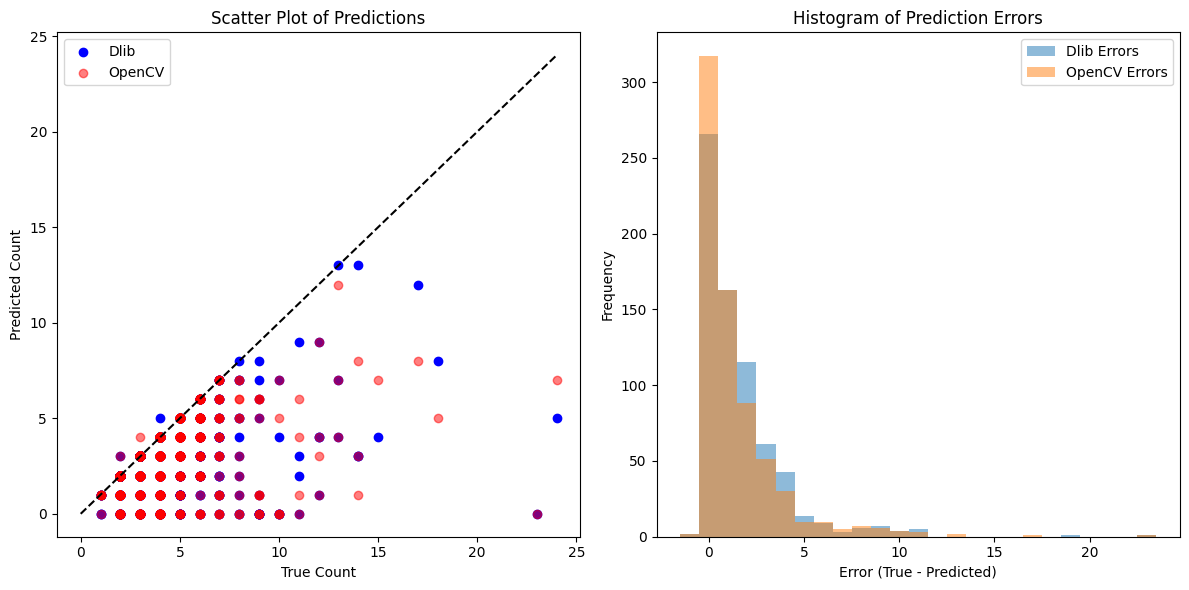

In [ ]:
# Calculate MAE and MSE
mae_dlib = np.mean(np.abs(merged_df["Faces True"] - merged_df["Faces Dlib"]))
mse_dlib = np.mean(np.square(merged_df["Faces True"] - merged_df["Faces Dlib"]))
mae_opencv = np.mean(np.abs(merged_df["Faces True"] - merged_df["Faces OpenCV"]))
mse_opencv = np.mean(np.square(merged_df["Faces True"] - merged_df["Faces OpenCV"]))

# Prepare data for plots
dlib_errors = merged_df["Faces True"] - merged_df["Faces Dlib"]
opencv_errors = merged_df["Faces True"] - merged_df["Faces OpenCV"]

# Scatter Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(merged_df["Faces True"], merged_df["Faces Dlib"], color='blue', label='Dlib')
plt.scatter(merged_df["Faces True"], merged_df["Faces OpenCV"], color='red', alpha=0.5, label='OpenCV')
plt.plot([0, max(merged_df["Faces True"])], [0, max(merged_df["Faces True"])], 'k--')  # Ideal line
plt.xlabel("True Count")
plt.ylabel("Predicted Count")
plt.title("Scatter Plot of Predictions")
plt.legend()

# Histogram of Errors
plt.subplot(1, 2, 2)
plt.hist(dlib_errors, bins=np.arange(min(dlib_errors)-0.5, max(dlib_errors)+1.5, 1), alpha=0.5, label='Dlib Errors')
plt.hist(opencv_errors, bins=np.arange(min(opencv_errors)-0.5, max(opencv_errors)+1.5, 1), alpha=0.5, label='OpenCV Errors')
plt.xlabel("Error (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors")
plt.legend()

plt.tight_layout()
plt.show()

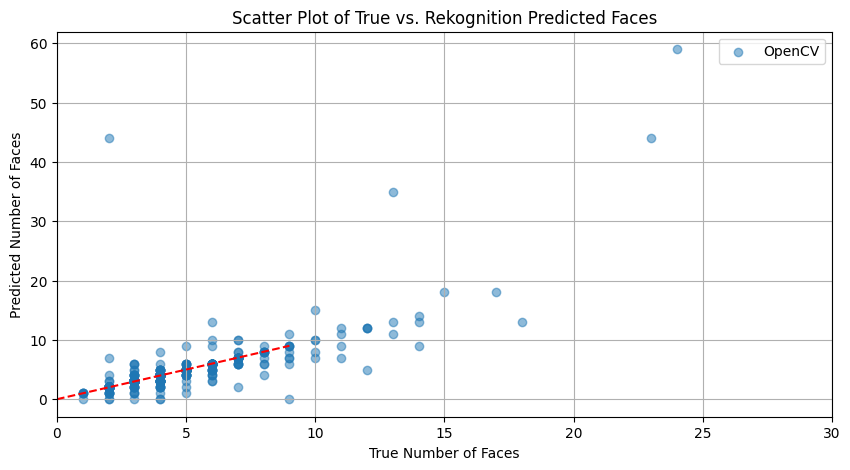

In [ ]:
# Scatter Plot of True vs. Predicted
plt.figure(figsize=(10, 5))
plt.scatter(merged_df['Faces True'], merged_df['Faces Rekognition'], alpha=0.5, label='OpenCV')
plt.plot([0, 9], [0, 9], 'r--') # Ideal line
plt.title('Scatter Plot of True vs. Rekognition Predicted Faces')
plt.xlabel('True Number of Faces')
plt.ylabel('Predicted Number of Faces')
plt.xlim(0, 30)  # Adjust x-axis to go from 0 to 30
plt.legend()
plt.grid(True)

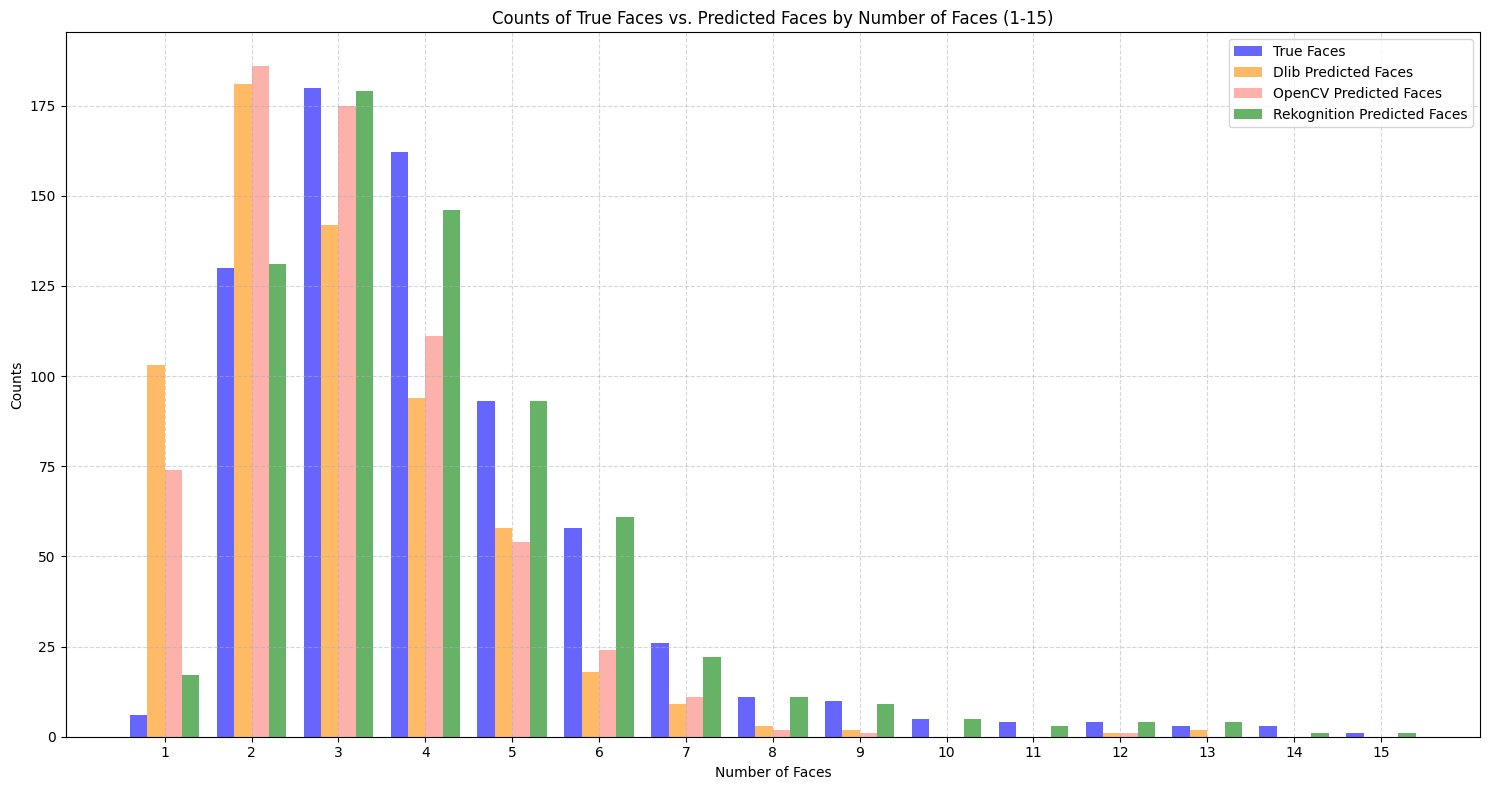

In [ ]:
# Bar Plot to show different counts in test data against the true label:

# Generate counts per number of faces
true_faces_counts = merged_df['Faces True'].value_counts().sort_index()
dlib_faces_counts = merged_df['Faces Dlib'].value_counts().sort_index()
opencv_faces_counts = merged_df['Faces OpenCV'].value_counts().sort_index()
rekognition_faces_counts = merged_df['Faces Rekognition'].value_counts().sort_index()  # New addition

# Reindexing all to ensure each has counts for 1 to 15 faces
all_face_numbers = np.arange(1, 16)  # 1 to 15 faces
true_faces_counts = true_faces_counts.reindex(all_face_numbers, fill_value=0)
dlib_faces_counts = dlib_faces_counts.reindex(all_face_numbers, fill_value=0)
opencv_faces_counts = opencv_faces_counts.reindex(all_face_numbers, fill_value=0)
rekognition_faces_counts = rekognition_faces_counts.reindex(all_face_numbers, fill_value=0)  # New addition

# Adjusting plotting
fig, ax = plt.subplots(figsize=(15, 8))

bar_width = 0.20  # Adjusted to fit the new group
index = np.arange(1, 16)  # 1 to 15

# Correcting the positions of the bars
bar1 = ax.bar(index - 1.5 * bar_width, true_faces_counts, bar_width, label='True Faces', color='b', alpha=0.6)
bar2 = ax.bar(index - 0.5 * bar_width, dlib_faces_counts, bar_width, label='Dlib Predicted Faces', color='darkorange', alpha=0.6)
bar3 = ax.bar(index + 0.5 * bar_width, opencv_faces_counts, bar_width, label='OpenCV Predicted Faces', color='salmon', alpha=0.6)
bar4 = ax.bar(index + 1.5 * bar_width, rekognition_faces_counts, bar_width, label='Rekognition Predicted Faces', color='green', alpha=0.6)  # New addition

ax.set_xlabel('Number of Faces')
ax.set_ylabel('Counts')
ax.set_title('Counts of True Faces vs. Predicted Faces by Number of Faces (1-15)')
ax.set_xticks(index)
ax.set_xticklabels(index)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


# Extraction of features:

In [ ]:
# Amazon Rekognition Client
rekognition_client = boto3.client(
    'rekognition',
    aws_access_key_id='XXXXX', # use your key
    aws_secret_access_key='XXXXX', # use your key
    region_name='eu-central-1')

In [ ]:
# Helper Function
def calculate_colorfulness(image):
    (B, G, R) = cv2.split(image.astype("float"))
    rg = np.absolute(R - G)
    yb = np.absolute(0.5 * (R + G) - B)
    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))
    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
    return stdRoot + (0.3 * meanRoot)

def sort_and_concatenate_text(text_detections):
    filtered_and_sorted_text_detections = sorted(
        [text for text in text_detections if text['Type'] == 'LINE'],
        key=lambda x: (x['Geometry']['BoundingBox']['Top'], x['Geometry']['BoundingBox']['Left'])
    )
    return " ".join([text['DetectedText'] for text in filtered_and_sorted_text_detections])


# Initialize the model for semantic similarity
model = SentenceTransformer('all-MiniLM-L6-v2')

# Assuming Google Cloud credentials are set as shown in your snippet
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/drive/XXXXX.json" # use your credentials

def detect_logos(path):
    """Detects logos in the file and returns the count of unique logos and a list of unique logos detected."""
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()

    image = vision.Image(content=content)
    response = client.logo_detection(image=image)

    if response.error.message:
        raise Exception(f'{response.error.message}')

    # Use a set comprehension to get distinct logos
    logos_set = {logo.description for logo in response.logo_annotations}
    logos = list(logos_set)  # Convert back to list if needed

    return len(logos), logos


# Initialize the sentiment analysis tools for video title
flair_classifier = TextClassifier.load('sentiment')
vader_analyzer = SentimentIntensityAnalyzer()

# Weights for each classifier's score
weights = {
    'vader': 1.0,
    'textblob': 0.0,
    'flair': 0.0,
}

# Function to analyze sentiment using all three classifiers
def analyze_combined_sentiment(text):
    # VADER Analysis
    vader_score = vader_analyzer.polarity_scores(text)['compound']

    # TextBlob Analysis
    textblob_score = TextBlob(text).sentiment.polarity

    # Flair Analysis
    sentence = Sentence(text)
    flair_classifier.predict(sentence)
    flair_score = sentence.labels[0].score
    if sentence.labels[0].value == 'NEGATIVE':
        flair_score *= -1

    # Calculate weighted average
    total_weight = sum(weights.values())
    avg_score = (weights['vader'] * vader_score +
                 weights['textblob'] * textblob_score +
                 weights['flair'] * flair_score) / total_weight

    return round(avg_score,3)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2024-04-12 12:40:39,344 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmp782wwed0


100%|██████████| 253M/253M [00:07<00:00, 37.3MB/s]

2024-04-12 12:40:46,600 copying /tmp/tmp782wwed0 to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2024-04-12 12:40:46,841 removing temp file /tmp/tmp782wwed0


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Main Function
def analyze_image_with_rekognition(image_path, video_title):
    with open(image_path, 'rb') as image_file:
        image_bytes = image_file.read()


    # Face detection:
    face_response = rekognition_client.detect_faces(Image={'Bytes': image_bytes}, Attributes=['ALL'])
    # Filter faces by confidence level >= 98
    face_details = [face for face in face_response['FaceDetails'] if face['Confidence'] >= 98]
    faces_count = len(face_details)
    all_gender = None
    all_emotion = None

    if faces_count > 0:
        # Process faces for gender and emotion
        genders = [face['Gender']['Value'] for face in face_details]
        emotions = [max(face['Emotions'], key=lambda x: x['Confidence'])['Type'] for face in face_details]

        # If all genders are the same, set all_gender to that gender; otherwise, 'Mixed'
        all_gender = genders[0] if all(g == genders[0] for g in genders) else 'Mixed'
        # If all emotions are the same, set all_emotion to that emotion; otherwise, 'Mixed'
        all_emotion = emotions[0] if all(e == emotions[0] for e in emotions) else 'Mixed'


    # Text detection:
    text_response = rekognition_client.detect_text(Image={'Bytes': image_bytes})

    # Filter for text detections with confidence >= 0.98
    high_confidence_text_detections = [
        text for text in text_response['TextDetections']
        if text['Confidence'] >= 98
    ]

    text_detected = "yes" if len(high_confidence_text_detections) > 0 else "no"
    detected_text = sort_and_concatenate_text(high_confidence_text_detections)

    # Label detection:
    try:
        label_response = rekognition_client.detect_labels(Image={'Bytes': image_bytes})
        labels = [label["Name"] for label in label_response["Labels"]]
        confidences = [label["Confidence"] for label in label_response["Labels"]]  # Always define confidences

        if labels:
            title_embedding = model.encode(video_title)
            label_embeddings = model.encode(labels)
            similarities = util.pytorch_cos_sim(title_embedding, label_embeddings).numpy().flatten()
            total_confidence = sum(confidences)
            normalized_confidences = [c / total_confidence for c in confidences]
            weighted_average_similarity = np.average(similarities, weights=normalized_confidences)
        else:
            weighted_average_similarity = "NA"  # Handle case with no labels detected
    except Exception as e:
        print(f"Error processing labels: {e}")
        weighted_average_similarity = "NA"  # Fallback in case of error

    # Google Vision Logo Detection
    logo_count, logos = detect_logos(image_path)

    # Sentiment Analysis on Title
    sentiment_video_title = analyze_combined_sentiment(video_title)

    # Colorfulness:
    image_for_color = cv2.imread(image_path)
    colorfulness_score = calculate_colorfulness(image_for_color)

    return faces_count, all_gender, all_emotion, text_detected, detected_text, round(colorfulness_score), weighted_average_similarity, logo_count, logos, sentiment_video_title


In [ ]:
# Execution

# Read main YT video information file (from the earlier stage):
file_path_csv = '/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/03_Final_Dataset/yt_video_stats_final.csv' #should be path of the final YT video csv
df = pd.read_csv(file_path_csv)

# Define the directory path where to find/read all YT thumbnails stored prior (also splited due to volume in six folders)
directory_path = "/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/00_YT_thumbnails_parts/06_part"

results = []

# List all .jpg files in the directory
try:
    file_names = [f for f in os.listdir(directory_path) if f.lower().endswith('.jpg')]
except OSError as e:
    print(f"Error accessing directory: {e}")
    print("Please check the directory path and permissions.")
    file_names = []  # Continue with an empty list if needed

for file_name in tqdm(file_names, desc="Processing images"):
    file_path = os.path.join(directory_path, file_name)
    video_title = df.loc[df['Video ID'] == os.path.splitext(file_name)[0], 'Video Title'].values[0]
    analysis_result = analyze_image_with_rekognition(file_path, video_title)
    results.append({
        "Video ID": os.path.splitext(file_name)[0],
        "Faces Rekognition": analysis_result[0],
        "All Gender": analysis_result[1],
        "All Emotion": analysis_result[2],
        "Text Detected": analysis_result[3],
        "Detected Text": analysis_result[4],
        "Colorfulness Score": analysis_result[5],
        "Semantic Similarity": analysis_result[6],
        "Logos Detected": analysis_result[7],
        "Detected Logos": analysis_result[8],
        "Video Title Sentiment": analysis_result[9],
    })


# Convert the list of dictionaries to a DataFrame
df_results = pd.DataFrame(results)

# Merge with the main DataFrame
merged_df = pd.merge(df, df_results, on="Video ID", how="left")

# Display and save the DataFrame
print(merged_df)

# Save df to csv
merged_df.to_csv('/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/03_Final_Dataset/yt_video_stats_final_enriched_6.csv', index=False)


Processing images: 100%|██████████| 3333/3333 [1:20:05<00:00,  1.44s/it]


                                             Video Title     Video ID  \
0      IS BUDGET NIGHTVISION ANY GOOD?? | WildGuarder...  CaCc68x098Y   
1      COMO A DIRETIVA ACABOU COM A FERRARI NA LUTA P...  woMFKz-NzSA   
2      One drawing, But 4 ✨Different✨ Styles! 👀 PART ...  _Qx0S_-J2fY   
3      Timi Zajc FALL at 161,5 m Willingen! Huge Jump...  EGSF1om4SAM   
4                                    It's pronounced GIF  Nrk8sqZfsgI   
...                                                  ...          ...   
19993  Must🤪Watch Amezing Special New Comedy Video 20...  TgxOBzCo4ac   
19994  FFXIV Endwalker - Part 24 (Lv 87) - Thou Must ...  Uqsd6aMTK9Q   
19995  How to Make Martha Stewart's Porchetta | Marth...  gb8J0B-PNs8   
19996                     ORAX - Crash (Full Album) 2023  Omm8pTF-4vU   
19997                                       ORAX - Crash  XabnONCdhkk   

                     Channel ID  \
0      UC9QK0Y_yFdIfYTdKp6FEMVg   
1      UCQ96zMdk6go-b2JujnQY_SQ   
2      UCCPsBYxLUy

In [ ]:
# Combine each part from before

import pandas as pd

# File paths
path1 = '/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/03_Final_Dataset/yt_video_stats_final_enriched_1.csv'
path2 = '/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/03_Final_Dataset/yt_video_stats_final_enriched_2.csv'
path3 = '/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/03_Final_Dataset/yt_video_stats_final_enriched_3.csv'
path4 = '/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/03_Final_Dataset/yt_video_stats_final_enriched_4.csv'
path5 = '/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/03_Final_Dataset/yt_video_stats_final_enriched_5.csv'
path6 = '/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/03_Final_Dataset/yt_video_stats_final_enriched_6.csv'

files = [path1, path2, path3, path4, path5, path6]

# List to hold DataFrames
data_frames = []

# Read each file into a DataFrame, filter it, and add to list
for file in files:
    df = pd.read_csv(file)
    # Drop rows where both 'Faces Rekognition' and 'Text Detected' are NaN
    filtered_df = df.dropna(subset=['Faces Rekognition', 'Text Detected'], how='all')
    data_frames.append(filtered_df)

# Concatenate all DataFrames
appended_df = pd.concat(data_frames, ignore_index=True)

# Check the result
print(appended_df.head())
print(appended_df.shape)

# Save the concatenated DataFrame to a new CSV file
appended_df.to_csv('/content/drive/MyDrive/08_Studies/01_HSLU/04_Semester_4/00_MasterThesis/01_Data/03_Final_Dataset/video_platform_engagement_data.csv', index=False)


                                         Video Title     Video ID  \
0  One drawing, But 4 ✨Different✨ Styles! 👀 PART ...  _Qx0S_-J2fY   
1   Why the Major League of Monster Trucks Failed...  3osyQ4Tl_o4   
2             Samsung Frame TV 85" unbox and install  kF95yK19aYU   
3  How to set Time, Date & Chronograph on Casio E...  J_CVMTFYJC0   
4     Avfx no deposit bonus 97$ live withdraw proofs  sVO9q2tqG6w   

                 Channel ID  \
0  UCCPsBYxLUykj5xbgOGTRzKQ   
1  UCN9bzNWgwvjHq8JKx4kpftw   
2  UCqJD36DTgvKVkbAkMwa5NdA   
3  UCybFkm7BymjwCungiY78wsQ   
4  UC3Tgdjsgw4VTtxyyAEw4wzg   

                                   Video Description  Video Views  \
0  💕sub to my Patreon here:  https://www.patreon....     46036531   
1  Monster Docs: Episode Two\nMany people conside...        55609   
2  Video of our unboxing and install of the Samsu...        11953   
3  #casio #edifice #settings \n\nHello viewers \n...        12281   
4  Watch Video : https://youtu.be/x1dMEFA_8GM\nBo... 